In [33]:
!pip install pandas sqlalchemy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("Online Sales Data.csv")  
df.head()


,Transaction ID,Date,Product Category,Product Name,Units Sold,Unit Price,Total Revenue,Region,Payment Method
0,10001,2024-01-01,Electronics,iPhone 14 Pro,2,999.99,1999.98,North America,Credit Card
1,10002,2024-01-02,Home Appliances,Dyson V11 Vacuum,1,499.99,499.99,Europe,PayPal
2,10003,2024-01-03,Clothing,Levi's 501 Jeans,3,69.99,209.97,Asia,Debit Card
3,10004,2024-01-04,Books,The Da Vinci Code,4,15.99,63.96,North America,Credit Card
4,10005,2024-01-05,Beauty Products,Neutrogena Skincare Set,1,89.99,89.99,Europe,PayPal


In [35]:
from sqlalchemy import create_engine, Table, Column, Integer, Float, String, MetaData, select, func, extract
from sqlalchemy.orm import Session

engine = create_engine("sqlite:///sales.db")
metadata = MetaData()


In [36]:
query = """
SELECT
    STRFTIME('%Y', Date) AS year,
    STRFTIME('%m', Date) AS month,
    SUM("Total Revenue") AS total_revenue,
    COUNT(DISTINCT "Transaction ID") AS order_volume
FROM
    orders
GROUP BY
    year, month
ORDER BY
    year, month;
"""

sales_trend = pd.read_sql_query(query, engine)
sales_trend


,year,month,total_revenue,order_volume
0,2024,01,14548.32,31
1,2024,02,10803.37,29
2,2024,03,12849.24,31
3,2024,04,12451.69,30
4,2024,05,8455.49,31
5,2024,06,7384.55,30
6,2024,07,6797.08,31
7,2024,08,7278.11,27


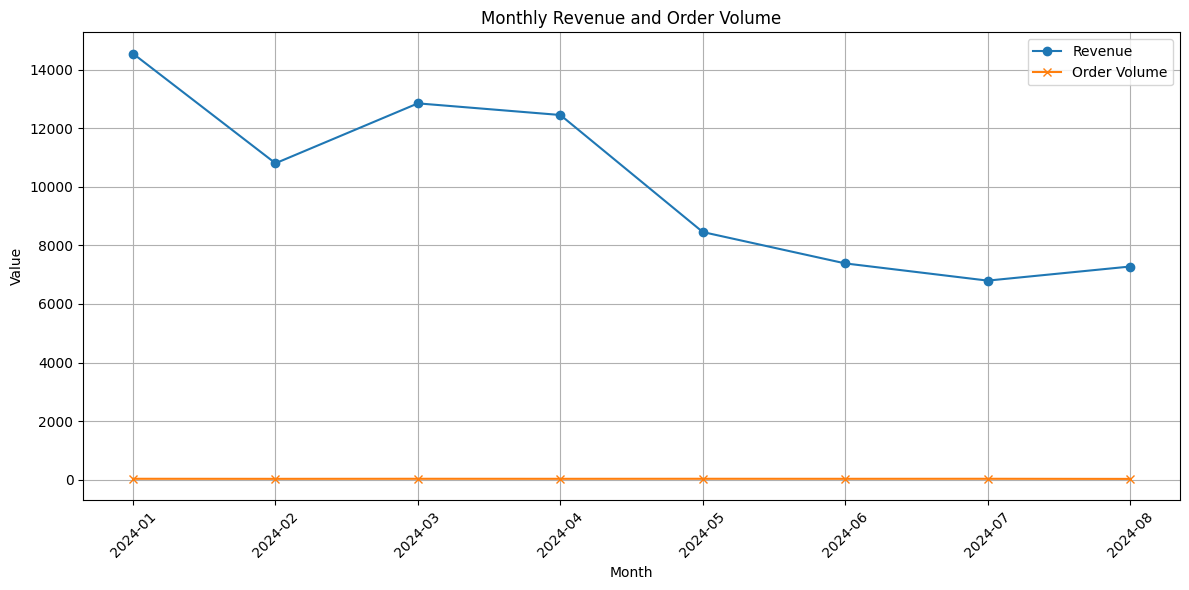

In [37]:
import matplotlib.pyplot as plt

# Combine year and month into one column
sales_trend["Period"] = sales_trend["year"] + "-" + sales_trend["month"]

plt.figure(figsize=(12,6))
plt.plot(sales_trend["Period"], sales_trend["total_revenue"], label="Revenue", marker='o')
plt.plot(sales_trend["Period"], sales_trend["order_volume"], label="Order Volume", marker='x')
plt.xticks(rotation=45)
plt.title("Monthly Revenue and Order Volume")
plt.xlabel("Month")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
df_sql = df.rename(columns={
    "Transaction ID": "order_id",
    "Date": "order_date",
    "Total Revenue": "amount",
    "Product Name": "product_id"
})[["order_id", "order_date", "amount", "product_id"]]

In [39]:
online_sales = Table(
    "online_sales", metadata,
    Column("order_id", Integer),
    Column("order_date", String),
    Column("amount", Float),
    Column("product_id", String)
)

metadata.create_all(engine)

In [40]:
df_sql.to_sql("online_sales", engine, index=False, if_exists="replace")

240

In [41]:
with Session(engine) as session:
    stmt = (
        select(
            extract('year', func.DATE(online_sales.c.order_date)).label("year"),
            extract('month', func.DATE(online_sales.c.order_date)).label("month"),
            func.sum(online_sales.c.amount).label("total_revenue"),
            func.count(func.distinct(online_sales.c.order_id)).label("order_volume")
        )
        .group_by("year", "month")
        .order_by("year", "month")
    )

    result = session.execute(stmt).fetchall()

In [42]:
result_df = pd.DataFrame(result, columns=["year", "month", "total_revenue", "order_volume"])
print(result_df)

   year  month  total_revenue  order_volume
0  2024      1       14548.32            31
1  2024      2       10803.37            29
2  2024      3       12849.24            31
3  2024      4       12451.69            30
4  2024      5        8455.49            31
5  2024      6        7384.55            30
6  2024      7        6797.08            31
7  2024      8        7278.11            27
